In [1]:
require 'torch'
require 'nn'
require 'image'
require 'optim'

In [2]:
loadcaffe_wrap = require 'loadcaffe_wrapper'
-- cjson = require 'cjson'
json = require 'json'
string = require 'string'
m = require 'manifold'

In [3]:

cmd = torch.CmdLine()

-- Hacking torch
cmd:option('-start_at', 1, 'index to start at – worst hack I\'ve ever written')
cmd:option('-iter', 100, 'how many images to run over – please don\'t segfault')
cmd:option('-img_size', 512, 'all images will be resized to this max dimension' )
cmd:option('-name', '', 'name to attach to output')
cmd:option('-thumb_size', 100, 'thumbnail size')


-- Basic options
cmd:option('-style_dir', 'data/picasso_braque/', 'Style input directory')
cmd:option('-tmp_dir', 'tmp/', 'Directory to store vectors on disk')
cmd:option('-gpu', -1, 'Zero-indexed ID of the GPU to use; for CPU mode set -gpu = -1')

-- Other options
cmd:option('-pooling', 'max', 'max|avg')
cmd:option('-proto_file', 'models/VGG_ILSVRC_19_layers_deploy.prototxt')
cmd:option('-model_file', 'models/VGG_ILSVRC_19_layers.caffemodel')

cmd:option('-content_layers', 'relu4_2', 'layers for content')
cmd:option('-style_layers', 'relu1_2,relu2_2,relu3_4,relu4_4,relu5_4', 'layers for style') -- tbh all but relu6 and relu7, which cause size mismatches
                            -- 'relu1_1,relu2_1,relu3_1,relu4_1,relu5_1'
                            -- 'relu1_1,relu1_2,relu2_1,relu2_2,relu3_1,relu3_2,relu3_3,relu3_4,relu4_1,relu4_2,relu4_3,relu4_4,relu5_1,relu5_2,relu5_3,relu5_4'


In [4]:
function cached(label) -- check if a cached version of vec exists
--     local layer_names = params.style_layers:gsub('relu',''):gsub(',','.')
    local filename = params.tmp_dir .. 'cache/' .. label  .. '.cache'
    local f = io.open(filename,"r")
    if f ~= nil then
        io.close(f)
        return true
    else
        return false
    end
end

function load_cache(label)
    print("loading  from cache...")
--     local layer_names = params.style_layers:gsub('relu',''):gsub(',','.')
    local filename = params.tmp_dir .. 'cache/' .. label  .. '.cache'
    local f = torch.load(filename)
    return f
end

function DEP_load_cache(label)
    print("loading  from cache...")
    local filename = params.tmp_dir .. 'cache/' .. label .. '.cache'
    local f = torch.load(filename)
    return f
end

function cache(file, label)
    if paths.dir(params.tmp_dir .. 'cache/') == nil then paths.mkdir(params.tmp_dir .. 'cache/') end

    local filename = params.tmp_dir .. 'cache/' .. label .. '.cache'
    local f = torch.save(filename, file)
    print(string.format("cached  %s", label))
    return true
end

In [5]:
function labels_to_jpg(path, embedding, labels)
    local map_im = draw_text_map(embedding, labels)
    image.save(path, map_im)
    return true
end

In [6]:

-------------------------------------------------------------------------------------


-- Returns a network that computes the CxC Gram matrix from inputs
-- of size C x H x W – jcjohnson's version
function GramMatrix()
    local net = nn.Sequential()
    net:add(nn.View(-1):setNumInputDims(2))
    local concat = nn.ConcatTable()
    concat:add(nn.Identity())
    concat:add(nn.Identity())
    net:add(concat)
    net:add(nn.MM(false, true))
    return net
end


-- utility function to reshape a tensor from M x N x ... to an MxN array
function flatten(t)
    return torch.view(t, -1)
end

-- a function to do memory optimizations by 
-- setting up double-buffering across the network.
-- this drastically reduces the memory needed to generate samples.
-- from soumith/dcgan.torch
function optimizeInferenceMemory(net)
    local finput, output, outputB
    net:apply(
        function(m)
            if torch.type(m):find('Convolution') then
                finput = finput or m.finput
                m.finput = finput
                output = output or m.output
                m.output = output
            elseif torch.type(m):find('ReLU') then
                m.inplace = true
            elseif torch.type(m):find('BatchNormalization') then
                outputB = outputB or m.output
                m.output = outputB
            end
    end)
end


function Style2Vec(cnn, gram, img)
    --[[ runs img through cnn, saving the output tensor at each of style_layers

    -- FOR NOW, only returns relu4_1

    relu1_1 : FloatTensor - size: 64x64
    relu1_2 : FloatTensor - size: 64x64
    relu2_1 : FloatTensor - size: 128x128
    relu2_2 : FloatTensor - size: 128x128
    relu3_1 : FloatTensor - size: 256x256
    relu3_2 : FloatTensor - size: 256x256
    relu3_3 : FloatTensor - size: 256x256
    relu3_4 : FloatTensor - size: 256x256
    relu4_1 : FloatTensor - size: 512x512
    relu4_2 : FloatTensor - size: 512x512
    relu4_3 : FloatTensor - size: 512x512
    relu4_4 : FloatTensor - size: 512x512
    relu5_1 : FloatTensor - size: 512x512
    relu5_2 : FloatTensor - size: 512x512
    relu5_3 : FloatTensor - size: 512x512
    relu5_4 : FloatTensor - size: 512x512
    
    Returns a Lua table with the above key-value pairs. 

    
    --]]
    
    local next_style_idx = 1
    local net = nn.Sequential()
    local style_layers = params.style_layers:split(',')
    
    local style_vector = nil 

    -- Build up net from cnn
    
    for i = 1, #cnn do

        if next_style_idx <= #style_layers then
            local layer = cnn:get(i)
            local layer_name = layer.name

            if params.gpu >= 0 then layer = layer:cuda() end

            net:add(layer)
            
            -- now to grab style layers
            
            if (layer_name == style_layers[next_style_idx]) then
                local target_features = net:forward(img)
                local target_i = gram:forward(target_features)
                target_i:div(target_features:nElement())
                
                -- add the current gram matrix (flattened) to style_vector
                local curr = flatten(target_i):float()
                if style_vector == nil then
                    style_vector = curr
                else
                    style_vector = nn.JoinTable(1):forward({style_vector, curr}):float()
                end

                next_style_idx = next_style_idx + 1     
            end
        end
    end

    collectgarbage(); collectgarbage()
    return style_vector
end


function save_json(filename, file)  
    local filename = 'tsnejs/tmp/' .. filename .. '.json'
    local json_string = json.encode(file)
    local f = io.open(filename, 'w')
    f:write(json_string)

    return true
end


function load(label) -- load and preprocess image

    -- Preprocess an image before passing it to a Caffe model.
    -- We need to rescale from [0, 1] to [0, 255], convert from RGB to BGR,
    -- and subtract the mean pixel. [jcjohnson]
    function preprocess(img)
      local mean_pixel = torch.DoubleTensor({103.939, 116.779, 123.68})
      local perm = torch.LongTensor{3, 2, 1}
      local img = img:index(1, perm):mul(256.0)
      mean_pixel = mean_pixel:view(3, 1, 1):expandAs(img)
      img:add(-1, mean_pixel)
      if params.gpu >= 0 then img = img:cuda() end
      return img
    end

    -- load our image
    local ok, img = pcall(image.load, params.style_dir .. label .. '.jpg')
    if not ok then 
        print('error loading image')
        return nil
    end

    if img:size()[1] ~= 3 then
        print('Not enough dimensions on this one')
        return nil
    end

    -- save thumbnail
    assert(save_thumb(img, label))

    -- preprocess for return
    img = image.scale(img, params.img_size, 'bilinear')
    img = preprocess(img):float()

    return img
end


function save_thumb(img, label)
    local thumbs = params.tmp_dir .. 'thumbs/'
    if paths.dir(thumbs) == nil then paths.mkdir(thumbs) end

    local thumb = image.scale(img, params.thumb_size, 'bilinear')
    image.save(thumbs .. label .. '.jpg', thumb)
    return true
end

In [7]:
-- function that draw text map: [modified from clementfarabet/manifold]
function draw_text_map(X, words, inp_map_size, inp_font_size)
  -- NOTE: This function assumes vocabulary is indexed by words, values indicate the index of a word into X!
  
    -- this function assumes embeddings normalized to 1... yech
    
  -- input options:
  local map_size  = inp_map_size or 512
  local font_size = inp_font_size or 9
  
  -- check inputs are correct:
  local N = X:size(1)
  if X:nDimension() ~= 2 or X:size(2) ~= 2 then
    error('This function is designed to operate on 2D embeddings only.')
  end
  if X:size(1) ~= #words then
    error('Number of words should match the number of rows in X.')
  end
    
    -- normalize data 
    X:add(-X:min())
    X:div( X:max())
  
  -- prepare image for rendering:
  require 'image'
  require 'qtwidget'
  require 'qttorch'
  local win = qtwidget.newimage(map_size, map_size)
  
  --render the words:
  for key,val in pairs(words) do
--     print(X[key])
    win:setfont(qt.QFont{serif = false, size = fontsize})
    win:moveto(math.floor(X[key][1] * 0.9 * map_size), math.floor(X[key][2] * map_size))
    win:show(val)
  end
  
  -- render to tensor:
  local map_im = win:image():toTensor()
  
  -- return text map:
  return map_im
end

In [8]:
function tsne(vecs, perplexity)
    local opts = {dim = 2, perplexity = perplexity}
    local p = m.embedding.tsne(vecs:double(), opts)
    return p
end

In [9]:
arg = {}
params = cmd:parse(arg)
if paths.dir(params.tmp_dir) == nil then paths.mkdir(params.tmp_dir) end

print(params)

{
  gpu : -1
  pooling : max
  content_layers : relu4_2
  style_dir : data/picasso_braque/
  img_size : 512
  proto_file : models/VGG_ILSVRC_19_layers_deploy.prototxt
  thumb_size : 100
  model_file : models/VGG_ILSVRC_19_layers.caffemodel
  style_layers : relu1_2,relu2_2,relu3_4,relu4_4,relu5_4
  iter : 100
  name : 
  start_at : 1
  tmp_dir : tmp/
}


In [10]:
-- gpu

if params.gpu >= 0 then
    require 'cutorch'
    require 'cunn'
    cutorch.setDevice(params.gpu + 1)
else
    params.backend = 'nn-cpu'
end

In [12]:
-- get sorted
sorted = {}
files = {}
for f in paths.iterfiles(params.style_dir) do    
    if string.match(f, '.jpg') then
        label = string.split(f, '.jpg')[1]
        table.insert(sorted, label)
        table.insert(files, params.style_dir .. f)
    end
end

table.sort(sorted)
for i,n in ipairs(sorted) do print(i, n) end


1	Braque1	
2	Braque2	
3	Braque3	
4	Braque4	
5	Braque5	
6	Braque6	
7	Braque7	
8	Braque8	
9	Picasso1	
10	Picasso2	
11	Picasso3	
12	Picasso4	
13	Picasso5	
14	Picasso6	
15	Picasso7	


In [13]:
-- load caffe network image

cnn = loadcaffe_wrap.load(params.proto_file, params.model_file, params.backend):float()
gram = GramMatrix():float()
if params.gpu >= 0 then 
    cnn = cnn:cuda()
    gram = gram:cuda() 
end
optimizeInferenceMemory(cnn)

collectgarbage(); collectgarbage()

Successfully loaded models/VGG_ILSVRC_19_layers.caffemodel


conv1_1: 64 3 3 3
conv1_2: 64 64 3 3
conv2_1: 128 64 3 3
conv2_2: 128 128 3 3
conv3_1: 256 128 3 3
conv3_2: 256 256 3 3
conv3_3: 256 256 3 3
conv3_4: 256 256 3 3
conv4_1: 512 256 3 3
conv4_2: 512 512 3 3
conv4_3: 512 512 3 3
conv4_4: 512 512 3 3
conv5_1: 512 512 3 3
conv5_2: 512 512 3 3
conv5_3: 512 512 3 3
conv5_4: 512 512 3 3
fc6: 1 1 25088 4096
fc7: 1 1 4096 4096
fc8: 1 1 4096 1000


In [17]:
-- Run Style2Vec on image by image

ct = 1
ct2 = 1
errct = 0
i = params.start_at

vecs = nil
imgs = nil
labels = {}

while (i < #sorted + 1) do
    label = sorted[i]
    io.write(ct .. ' ' .. label .. ':\t')        --      .. params.style_layers .. ' ...' 

    local timer = torch.Timer()
    local vec = nil

    local img = load(label)

    if cached(label) then
        vec = load_cache(label)
    else        
        if img == nil then
            print('error loading image')        -- note: if cache exists, we don't check the image itself
            errct = errct + 1
        else
            vec = Style2Vec(cnn, gram, img)
            cache(vec, label)
        end
    end

    if vec ~= nil then
        if vecs == nil then
            vecs = vec
        else
            vecs = nn.JoinTable(1):forward({vecs, vec}):float()
            ct = ct + 1
        end

        -- resize all images to 512x512 before flattening to preserve dims
        local std_img = image.scale(img, 512, 512, 'bicubic')
        local flat_std = flatten(std_img)

        if imgs == nil then
            imgs = flat_std
        else
            imgs = nn.JoinTable(1):forward({imgs, flat_std}):float()
            ct2 = ct2 + 1
        end
    
        labels[ct] = label
    end

    i = i + 1
--     if ct > params.iter then break end
    collectgarbage(); collectgarbage()

    print(string.format("elapsed time: %.2f\n", timer:time().real))
end
print(string.format("error loading %d images", errct))

1 Braque1:	loading  from cache...	
elapsed time: 0.18
	
1 Braque2:	loading  from cache...	
elapsed time: 0.19
	
2 Braque3:	loading  from cache...	
elapsed time: 0.12
	
3 Braque4:	loading  from cache...	
elapsed time: 0.20
	
4 Braque5:	loading  from cache...	
elapsed time: 0.21
	
5 Braque6:	loading  from cache...	
elapsed time: 0.19
	
6 Braque7:	loading  from cache...	
elapsed time: 0.25
	
7 Braque8:	loading  from cache...	
elapsed time: 0.32
	
8 Picasso1:	loading  from cache...	
elapsed time: 0.24
	
9 Picasso2:	

loading  from cache...	


elapsed time: 2.29
	
10 Picasso3:	

cached  Picasso3	
elapsed time: 12.01
	
11 Picasso4:	loading  from cache...	
elapsed time: 0.27
	
12 Picasso5:	loading  from cache...	
elapsed time: 0.34
	
13 Picasso6:	loading  from cache...	
elapsed time: 0.31
	
14 Picasso7:	loading  from cache...	


elapsed time: 0.40
	
error loading 0 images	


In [ ]:
-- -- clean up a little
-- cnn = nil
-- style_images = nil
-- collectgarbage(); collectgarbage()

In [18]:
-- reshape into rows for export and t-SNE
print('reshaping vecs: ')
vecs = vecs:view(ct, -1)
imgs = imgs:view(ct2, -1)
print(#vecs)
print(#imgs)

reshaping vecs: 	

     15
 610304
[torch.LongStorage of size 2]


     15
 786432
[torch.LongStorage of size 2]



Embedding at 11: 	
Computing P-values...	
Running t-SNE...	
Iteration 100: KL divergence is 27.488963732981	
Iteration 200: KL divergence is 1.4630587532344	
Iteration 300: KL divergence is 0.30934677538012	


Iteration 400: KL divergence is 0.23311187403534	


Iteration 500: KL divergence is 0.21698226723205	


Iteration 600: KL divergence is 0.21208043866473	


Iteration 700: KL divergence is 0.20874951657439	


Iteration 800: KL divergence is 0.20523165345975	


Iteration 900: KL divergence is 0.20333045625773	


Iteration 1000: KL divergence is 0.20251786655158	


saving embedding to pb_11emb	


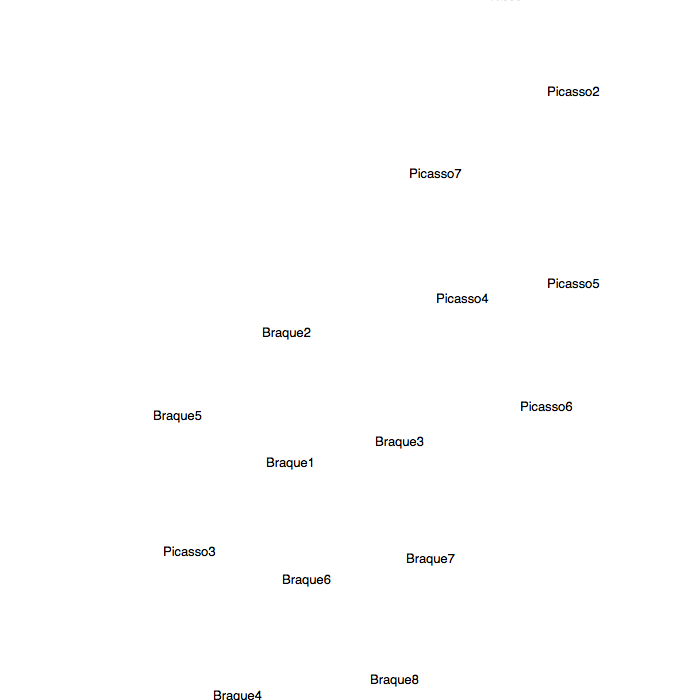

Embedding at 13: 	


Computing P-values...	


Running t-SNE...	


Iteration 100: KL divergence is 22.689577018964	


Iteration 200: KL divergence is 2.7554077330083	


Iteration 300: KL divergence is 0.64780191355002	


Iteration 400: KL divergence is 0.48416176620051	


Iteration 500: KL divergence is 0.39860678424149	


Iteration 600: KL divergence is 0.36016366780841	


Iteration 700: KL divergence is 0.32300188365031	


Iteration 800: KL divergence is 0.31639966859599	


Iteration 900: KL divergence is 0.31494597554892	


Iteration 1000: KL divergence is 0.31271739973114	


saving embedding to pb_13emb	


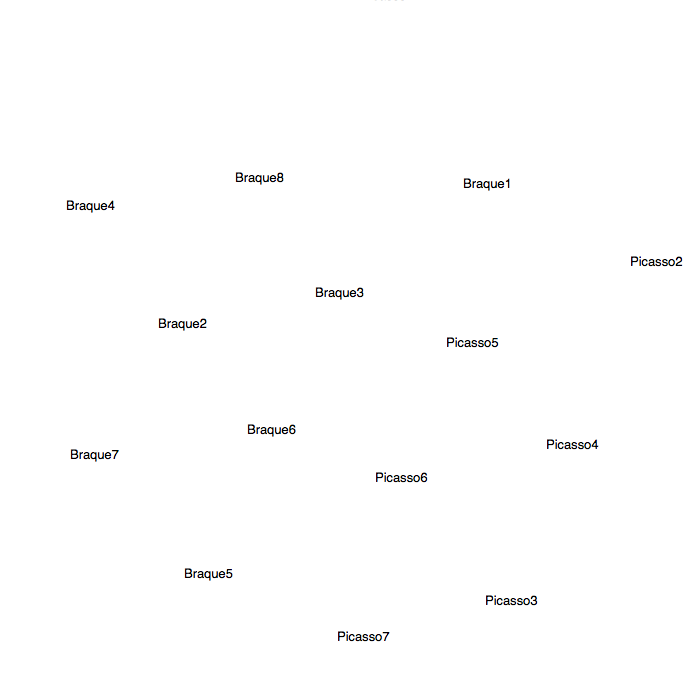

Embedding at 15: 	


Computing P-values...	


Running t-SNE...	


Iteration 100: KL divergence is 25.621921497928	


Iteration 200: KL divergence is 1.7436874678961	


Iteration 300: KL divergence is 0.38041650321432	


Iteration 400: KL divergence is 0.3559207364749	


Iteration 500: KL divergence is 0.35591855978995	


Iteration 600: KL divergence is 0.35591855978995	


Iteration 700: KL divergence is 0.3556907209903	


Iteration 800: KL divergence is 0.35563429188814	


Iteration 900: KL divergence is 0.35563398508759	


Iteration 1000: KL divergence is 0.35354594449547	


saving embedding to pb_15emb	


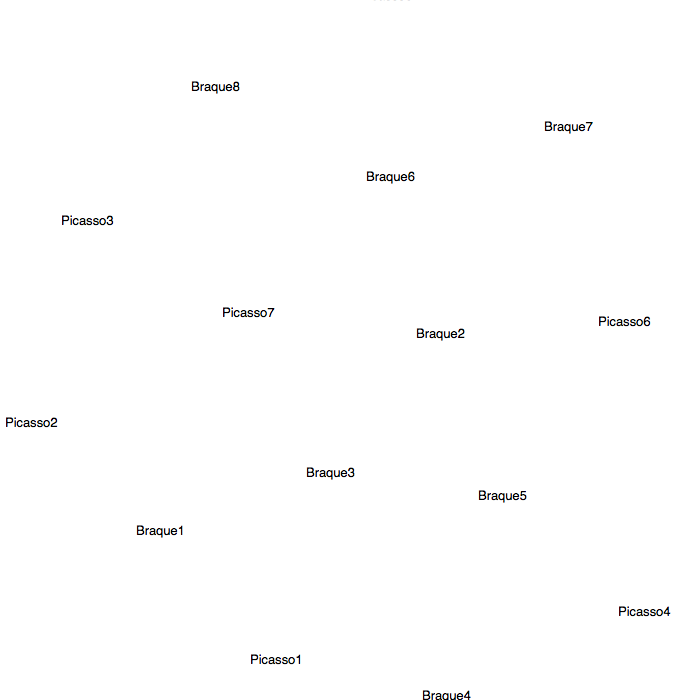

Embedding at 17: 	


Computing P-values...	


Running t-SNE...	


Iteration 100: KL divergence is 32.43096252921	


Iteration 200: KL divergence is 1.3321725102395	


Iteration 300: KL divergence is 0.36781349792361	


Iteration 400: KL divergence is 0.34738263837586	


Iteration 500: KL divergence is 0.34730806799134	


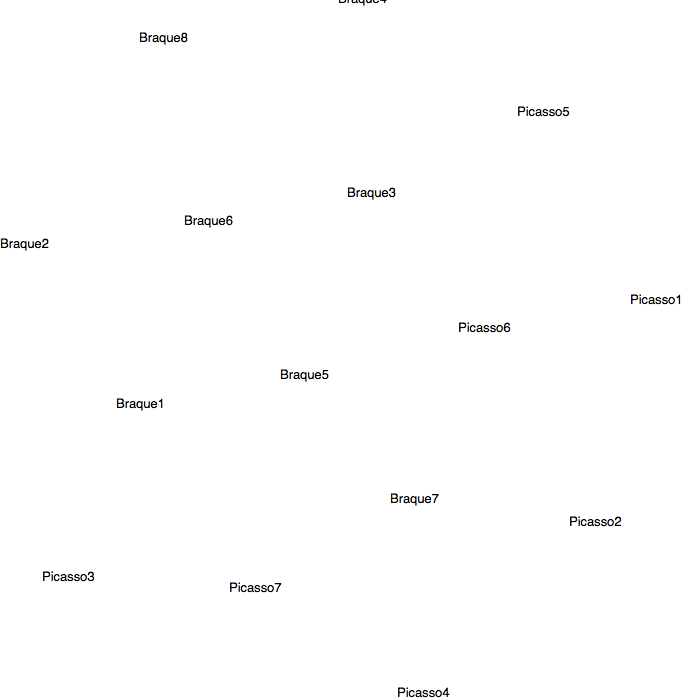

Iteration 600: KL divergence is 0.34712637748506	
Iteration 700: KL divergence is 0.34662266707206	
Iteration 800: KL divergence is 0.3448464422565	
Iteration 900: KL divergence is 0.34479548160564	
Iteration 1000: KL divergence is 0.34479238042269	
saving embedding to pb_17emb	


In [19]:
params.name = 'pb_'
perplexities = { 11, 13, 15, 17}

for _, i in pairs(perplexities) do
    print(string.format('Embedding at %d: ', i))

    local embedding = tsne(vecs, i)
    local map_im = draw_text_map(embedding, labels, 700, 9)
    print('saving embedding to '.. params.name .. i .. 'emb')
    assert(save_json(params.name .. i .. 'emb', embedding:totable()))
    
    itorch.image(map_im)                   -- labels_to_jpg('text_embedding.jpg', embedding, out)
    os.execute("sleep " .. tonumber(0.5))
end

In [23]:
save_json(params.name .. 'labels', labels)
print(json.encode(labels))

["Braque1","Braque2","Braque3","Braque4","Braque5","Braque6","Braque7","Braque8","Picasso1","Picasso2","Picasso3","Picasso4","Picasso5","Picasso6","Picasso7"]	
